# Neural Machine Translation (NMT)

In [1]:
rm -rf /kaggle/working/neural-machine-translation

In [2]:
!git clone --single-branch --branch data_prep https://github.com/mariaafara/neural-machine-translation.git

Cloning into 'neural-machine-translation'...
remote: Enumerating objects: 90, done.
remote: Counting objects: 100% (90/90), done.
remote: Compressing objects: 100% (58/58), done.
remote: Total 90 (delta 31), reused 82 (delta 27), pack-reused 0
Unpacking objects: 100% (90/90), done.


In [3]:
%ls

__notebook__.ipynb  neural-machine-translation/


In [4]:
import time
import sys  
import numpy as np
import pandas as pd
import sys
sys.path.insert(0, 'neural-machine-translation/nmt/')
import pickle as pkl
from model.encoder import Encoder
from model.decoder import Decoder
from dataPreparator import DataPreparator
from dataGenerator import DataGenerator
import tensorflow as tf
import datetime as datetime
from sklearn.model_selection import train_test_split
pd.set_option('display.max_colwidth', None)
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings('ignore')


### Download and prepare the dataset
We will use a parallel dataset provided by http://www.statmt.org/europarl/ for french-english languages.

In [5]:
# ! wget http://www.statmt.org/europarl/v7/fr-en.tgz
# !tar -xzvf fr-en.tgz

After downloading the dataset, here are the steps we will take to prepare the data:
1. Load the dataset (optional: load a perecentage of the dataset to experiment faster; keeping in mind that the quality of the translation degrades with less data)
2. Normalize sentences by lowercasing and separating punctuations from words.
3. Transform the data into paris of (src lang sentence, target language sentence).
4. Filter out sentences by selecting only sentences with a max sequence length (optional).
5. Create a Language class for each source and target languages of which it creates dictionaries to map from word → id and id → word.
6. Convert sentences into numerical values using word → id dictionaries.
7. Pad each sentence to either a maximum length or the maximum length of the sequences.
8. Sort the dataset into batches (creating BatchDataset).
9. Split the dataset into train val sets (you can specify the ration of val size (test_size))

In [6]:
MAX_LENGTH = 10
BATCH_SIZE = 64
src_lang = "english"
target_lang = "french"
src_path = "/kaggle/input/englishfrench-corpus/europarl-v7.fr-en.en"
target_path = "/kaggle/input/englishfrench-corpus/europarl-v7.fr-en.fr"

A standard format used in NMT is the parallel text format. It consists of a pair of plain text with files corresponding to source sentences and target translations, aligned line-by-line.

In [7]:
data_preparator = DataPreparator(src_lang, target_lang, src_path, target_path, max_length=MAX_LENGTH, 
                                    percentage=100, filter_by_length=True, test_size=0.2)

In [8]:
lang_dic, train_df, val_df = data_preparator.prepare()

We have loaded 2007723 sentences for english lang
We have loaded 2007723 sentences for french lang
Filtering sentences with max length < 10 results in:
106542 sentence for each language


In [9]:
lang_dic

{'english': <dataPreparator.Lang at 0x7f8d97f34f90>,
 'french': <dataPreparator.Lang at 0x7f8d97f34fd0>}

In [10]:
eos = lang_dic[target_lang].word2int["<EOS>"]
sos = lang_dic[target_lang].word2int['<SOS>']

In [11]:
pkl.dump(lang_dic, open("lang_dic9.pkl","wb"))
pkl.dump(train_df, open("train_df9.pkl","wb"))
pkl.dump(val_df, open('val_df9,pkl','wb'))

In [12]:
print("An example aligned sentences:")
train_df.head()

An example aligned sentences:


,english,french
173184,so 29 countries have signed up to it .,vingt-neuf pays l' ont maintenant signé.
817166,it is extremely clear .,elle est parfaitement claire .
1808090,we should make sure he gets those resources .,nous devons nous assurer qu'elle reçoit ces ressources .
900203,that is a hypothesis .,c'est une hypothèse .
817660,"however , it is more than that .",c'est toutefois plus que cela .


In [13]:
train_gen = DataGenerator(lang_dic, train_df, MAX_LENGTH, BATCH_SIZE)

In [14]:
val_target_sentences= val_df[target_lang].tolist()
val_source_sentences = val_df[src_lang].tolist()

In [15]:
# for b in train_gen:
#     print(b[0])
#     break

## In this version we will try the general encoder-decoder architecture for NMT.

NMT is the process of mapping sequence inputs (sequence of source sentence words) to sequence outputs (sequence of translated sentence words).
This is done using Sequence to Sequence models (Seq2Seq). Seq2Seq can process variable-length source inputs, mapping them to variable-length target outputs using  Encoder-decoder architecture.<br>

It consists of 2 networks:
- Encoder - Is the network where the input is encoded. It represents the input text corpus (Source language text) in the form of embedding vectors and trains the model.

- Decoder - Is the other network which generates the translation. It receives a fixed size vector from the encoder to decode the outputs into target language words. 

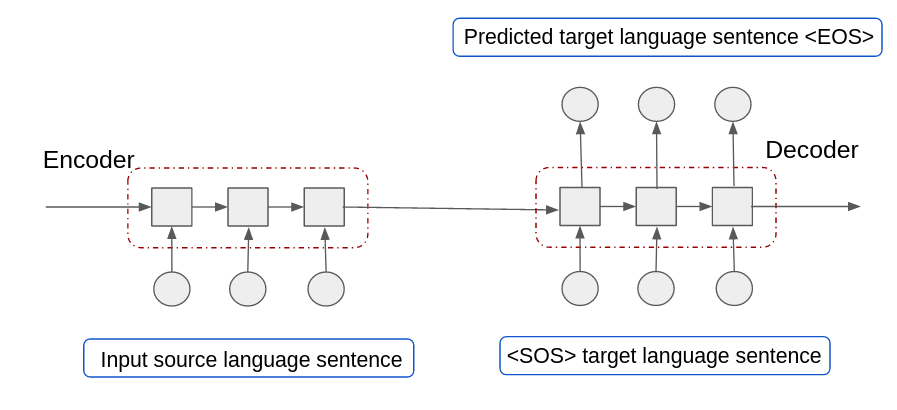

In further details:<br>
The seq2seq models are a special class of Recurrent Neural Networks.<br>
The RNN Encoder-Decoder architecture is comprised of two recurrent neural networks - i.e., encoder and decoder.<br>
The RNN encoder takes a variable-length sequence as the input and transforms it into a fixed-shape hidden state. In other words, information of the input sequence is encoded in the hidden state of the RNN encoder.<br>
To generate the output sequence token by token, a separate RNN decoder can predict the next token based on what tokens have been seen (such as in language modeling) or generated, together with the encoded information of the input sequence.
<br>
The minds behind this architecture are Ilya Sutskever, Oriol Vinyals and Quoc V. Le.  Link to paper: https://arxiv.org/pdf/1409.3215.pdf

In this work we can either choose to use LSTM/GRU encoder and decoder.

## Define the Encoder and Decoder

In [16]:
# lang_dic = pkl.load(open("/kaggle/input/version4/lang_dic.pkl","rb"))

In [17]:
EMBEDDING_SIZE = 32
rnn_units = 64
with_attention = True

src_vocab_size = lang_dic[src_lang].n_words + 1
target_vocab_size = lang_dic[target_lang].n_words + 1

encoder = Encoder(src_vocab_size, EMBEDDING_SIZE, rnn_units, batch_size=BATCH_SIZE, unit_type=Encoder.GRU_UNIT)

decoder = Decoder(target_vocab_size, EMBEDDING_SIZE, rnn_units, unit_type=Encoder.GRU_UNIT, with_attention=with_attention)

## Checkpoints (Object-based saving)

In [18]:
def checkpoint(model, name=None):
    if name is not None:
        model.save_weights('{}.h5'.format(name))
    else:
        raise NotImplementedError

## Do the training

@tf.function is used as a decorator to take advance of static graph computation (remove it inorder to debug)</br>
The computations of the network need to be put under tf.GradientTape() to keep track of gradients

1. Pass the input through the encoder which return encoder output and the encoder hidden state.
2. Prepare the decoder input (which is the start token) and initial states (whish is the encoder hidden state/s).
3. Pass them to the decoder and it returns the predictions and the decoder hidden state/s.
4. The decoder predictions and target output are used to calculate the loss.
5. The decoder hidden state/s is then passed back into the decoder model.
6. Use teacher forcing to decide the next input to the decoder.
7. The final step is to calculate the gradients and apply it to the optimizer and backpropagate.

In [19]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

def evaluate(sentence):
    attention_plot = np.zeros((MAX_LENGTH, MAX_LENGTH))
    val_sentence = data_preparator.normalize_string(sentence)
    val_sentence = train_gen.sentence_to_indexes(val_sentence, lang_dic[src_lang])
    val_sentence = tf.keras.preprocessing.sequence.pad_sequences([val_sentence],padding='post',
                                                    maxlen=MAX_LENGTH, truncating='post')

    result = ''

    hidden = [tf.zeros((1, rnn_units))]
    enc_out, enc_hidden = encoder(val_sentence, hidden)

    dec_hidden = enc_hidden
    dec_input = tf.expand_dims([sos], 0)

    for t in range(MAX_LENGTH):
        predictions, dec_hidden, attention_weights = decoder(dec_input,
                                                         dec_hidden,
                                                         enc_out)

        # storing the attention weights to plot later on
        attention_weights = tf.reshape(attention_weights, (-1, ))
        attention_plot[t] = attention_weights.numpy()

        predicted_id = tf.argmax(predictions[0]).numpy()
        result += lang_dic[target_lang].int2word[predicted_id] + ' '
        if lang_dic[target_lang].int2word[predicted_id] == lang_dic[target_lang].int2word[eos]:
            print("yes")
            return result, sentence, attention_plot

        # the predicted ID is fed back into the model
        dec_input = tf.expand_dims([predicted_id], 0)
    
    return result, sentence, attention_plot

# function for plotting the attention weights
def plot_attention(attention, sentence, predicted_sentence):
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(1, 1, 1)
    ax.matshow(attention, cmap='viridis')

    fontdict = {'fontsize': 14}

    ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
    ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)

    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()
    
def translate(sentence,target, plot=False):
    result, sentence, attention_plot = evaluate(sentence)

    print('Input: %s' % (sentence))
    print('Target translation: {}'.format(target))
    print('Predicted translation: {}'.format(result))
    if plot:
        attention_plot = attention_plot[:len(result.split(' ')), :len(sentence.split(' '))]
        plot_attention(attention_plot, sentence.split(' '), result.split(' '))

In [20]:
translate('we must not let this happen again.','il ne faut pas que cela se reproduise .')

Input: we must not let this happen again.
Target translation: il ne faut pas que cela se reproduise .
Predicted translation: améliorées". «socrates» dites naissance oignons vivez-vous 462 (h-0791/98): trions vatican 


In [21]:
# @tf.function
def train_step(source_sequence, target_sequence, encoder_initial_states):
    
    loss = 0
    
    with tf.GradientTape() as tape:
        
        # step 1
        enc_output, enc_states = encoder(source_sequence, encoder_initial_states) 
        
        # step 2
#         enc_states = enc_outputs[1:]
        dec_states = enc_states
        dec_input = tf.expand_dims([lang_dic[target_lang].word2int['<SOS>']] * BATCH_SIZE, 1)

        for t in range(1, target_sequence.shape[1]):
            # step 3 - 5
            if with_attention:
                predictions, dec_states, _ = decoder(dec_input, dec_states, enc_output)
            else:
                predictions, dec_states = decoder(dec_input, dec_states)
            
            # step 4
            loss += loss_function(target_sequence[:, t], predictions)
            
            # step 6
            # using teacher forcing technique - feeding the target word as the next input to the decoder
            dec_input = tf.expand_dims(target_sequence[:, t], 1)
            
    # step 7 
    batch_loss = (loss / int(target_sequence.shape[1]))

    variables = encoder.trainable_variables + decoder.trainable_variables

    gradients = tape.gradient(loss, variables)

    optimizer.apply_gradients(zip(gradients, variables))

    return batch_loss

In [22]:
# from nltk.translate.bleu_score import corpus_bleu

# val_source_sentence = "I cannot answer that question."
# val_target_sentence = "je ne peux répondre à cette question ."
# val_sentence = data_preparator.normalize_string(val_source_sentence)
# val_sentence = train_gen.sentence_to_indexes(val_sentence, lang_dic[src_lang])
# val_sentence = tf.keras.preprocessing.sequence.pad_sequences([val_sentence],padding='post',
#                                                 maxlen=MAX_LENGTH, truncating='post')

# sentences = [data_preparator.normalize_string(sentence) for sentence in val_source_sentences]
# sentences = [train_gen.sentence_to_indexes(sentence, lang_dic[src_lang]) for sentence in sentences]
# sentences = tf.keras.preprocessing.sequence.pad_sequences(sentences,padding='post',
#                                                 maxlen=MAX_LENGTH, truncating='post')

# def bleu_scores(references, candidates):
#     "BLEU scores are based on an average of unigram, bigram, trigram and 4-gram precision"
#     bleu_1 = corpus_bleu(references, candidates, weights=(1.0, 0, 0, 0),)
#     print("bleu{} {}".format(1,bleu_1))
#     bleu_2 = corpus_bleu(references, candidates, weights=(0.5, 0.5, 0, 0))
#     print("bleu{} {}".format(2,bleu_2))    
#     bleu_3 = corpus_bleu(references, candidates, weights=(0.3, 0.3, 0.3, 0))
#     print("bleu{} {}".format(3,bleu_3))
#     bleu_4 = corpus_bleu(references, candidates, weights=(0.25, 0.25, 0.25, 0.25))
#     print("bleu{} {}".format(4,bleu_4))
#     return bleu_1, bleu_2, bleu_3 , bleu_4

# # Evaluate the model
# def evaluate_model(references, sentences):
#     "BLEU scores are based on an average of unigram, bigram, trigram and 4-gram precision"
#     candidates = translate(sentences,eos,sos,BATCH_SIZE=100)
#     references = references[:len(candidates)]
#     bleu_1, bleu_2, bleu_3 , bleu_4 = bleu_scores(references, candidates)
#     return bleu_1, bleu_2, bleu_3 , bleu_4

In [23]:
# encoder.load_weights("/kaggle/input/version4/encoder8.h5")
# decoder.load_weights("/kaggle/input/version4/decoder8.h5")

## Start the training loop. 
At every epoch, we will grab batches of data for training. We also print out the loss value and see how the model performs at the end of each epoch.

In [24]:
# # Load the TensorBoard notebook extension
# %load_ext tensorboard
# # %reload_ext tensorboard

# # Clear any logs from previous runs
# !rm -rf ./logs/

# current_time = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
# train_log_dir = 'logs/gradient_tape/' + current_time + '/train'
# test_log_dir = 'logs/gradient_tape/' + current_time + '/test'
# train_summary_writer = tf.summary.create_file_writer(train_log_dir)
# test_summary_writer = tf.summary.create_file_writer(test_log_dir)

In [25]:
### Define the optimizer and the loss function
def loss_function(targets, predictions):
    crossentropy = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True) #criterion
    mask = tf.math.logical_not(tf.math.equal(targets, 0))
    mask = tf.cast(mask, dtype=tf.int64)
    loss = crossentropy(targets, predictions, sample_weight=mask)
    return loss

# optimizer = tf.keras.optimizers.Adam(1e-3)
# lr_schedule = tf.keras.callbacks.LearningRateScheduler(
#     lambda epoch: 1e-8 * 10**(epoch / 20))

steps_per_epoch = train_gen.__len__()
learning_rate_fn = tf.keras.optimizers.schedules.PiecewiseConstantDecay(
    [80*steps_per_epoch, 120*steps_per_epoch, 160*steps_per_epoch, 180*steps_per_epoch],
    [1e-3, 1e-4, 1e-5, 1e-6, 5e-6]
)

optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate_fn)

In [26]:
def train(EPOCHS, log_every):

    # Keep results for plotting
    train_loss_results = []
#     val_bleu1 = []
#     val_bleu2 = []
#     val_bleu3 = []
#     val_bleu4 = []

    for epoch in range(EPOCHS):
        # Start epoch
        start = time.time()

        total_loss = 0.0
        enc_state = encoder.initialize_hidden_state()

        for batch_idx, batch_inputs_targets in enumerate(train_gen):
            batch_inputs = batch_inputs_targets[0]
            batch_outputs = batch_inputs_targets[1]

            batch_loss = train_step(batch_inputs, batch_outputs, enc_state)
            total_loss += batch_loss

            if batch_idx % log_every == 0:
                print('Epoch {} Batch {} Batch Loss {:.4f}'.format(epoch+1, batch_idx, batch_loss.numpy()))

        # End epoch
        total_loss = total_loss / steps_per_epoch
        train_loss_results.append(total_loss)

    #     with train_summary_writer.as_default():
    #         tf.summary.scalar('loss', total_loss, step=epoch)

        print("Epochs: {} total_loss: {:.4f}".format(epoch+1, total_loss))
        print("Testing:")
        translate('we must not let this happen again.','il ne faut pas que cela se reproduise .')
        print('Time taken for epoch{} {} sec\n'.format(epoch+1,time.time() - start))

#         bleu_1, bleu_2, bleu_3 , bleu_4 = evaluate_model(val_target_sentences, sentences)

    #     with test_summary_writer.as_default():
    #         tf.summary.scalar('bleu-1', bleu_1, step=epoch)
    #         tf.summary.scalar('bleu-2', bleu_2, step=epoch)
    #         tf.summary.scalar('bleu-3', bleu_3, step=epoch)
    #         tf.summary.scalar('bleu-4', bleu_4, step=epoch)

#         val_bleu1.append(bleu_1)
#         val_bleu2.append(bleu_2)
#         val_bleu3.append(bleu_3)
#         val_bleu4.append(bleu_4)
#         print("------")
#         print("Testing the model on a sentence:")
#         print("original sentence: {} -> target sentence: {}".format(val_source_sentence,val_target_sentence))
#         print("transaltes sentence: {}".format(" ".join(x for x in translate(val_sentence,eos,sos,1)[0])))
#         print("------")
        print('saving checkpoint')
        if epoch+1 % 5 ==0:
    #         checkpoint every 5 epochs
            checkpoint(encoder, 'encoder{}'.format(epoch+1))
            checkpoint(decoder, 'decoder{}'.format(epoch+1))
 


In [27]:
train(EPOCHS = 5, log_every = 201)

Epoch 1 Batch 0 Batch Loss 7.1177
Epoch 1 Batch 201 Batch Loss 4.0851
Epoch 1 Batch 402 Batch Loss 4.1227
Epoch 1 Batch 603 Batch Loss 4.0474
Epoch 1 Batch 804 Batch Loss 3.6820
Epoch 1 Batch 1005 Batch Loss 3.7844
Epoch 1 Batch 1206 Batch Loss 3.5832
Epochs: 1 total_loss: 3.9475
Testing:
Input: we must not let this happen again.
Target translation: il ne faut pas que cela se reproduise .
Predicted translation: ne nous nous nous nous nous nous nous nous nous 
Time taken for epoch1 207.3687882423401 sec

saving checkpoint
Epoch 2 Batch 0 Batch Loss 3.6939
Epoch 2 Batch 201 Batch Loss 3.4433
Epoch 2 Batch 402 Batch Loss 3.5641
Epoch 2 Batch 603 Batch Loss 3.4253
Epoch 2 Batch 804 Batch Loss 3.0368
Epoch 2 Batch 1005 Batch Loss 3.1684
Epoch 2 Batch 1206 Batch Loss 2.9794
Epochs: 2 total_loss: 3.2588
Testing:
yes
Input: we must not let this happen again.
Target translation: il ne faut pas que cela se reproduise .
Predicted translation: ne pouvons pas pas . <EOS> 
Time taken for epoch2 206.

In [28]:
# import matplotlib.pyplot as plt

# fig, axes = plt.subplots(2, sharex=True, figsize=(12, 8))
# fig.suptitle('Training Metrics')

# axes[0].set_ylabel("Loss", fontsize=14)
# axes[0].plot(train_loss_results)

# axes[1].set_ylabel("Bleus", fontsize=14)
# axes[1].set_xlabel("Epoch", fontsize=14)
# axes[1].plot(val_bleu1, label="bleu1")
# axes[1].plot(val_bleu2, label="bleu2")
# axes[1].plot(val_bleu3, label="bleu3")
# axes[1].plot(val_bleu4, label="bleu4")
# axes[1].legend(loc="left")

# plt.show()

In [29]:
# %tensorboard --logdir logs/gradient_tape

## Restore the latest checkpoint and test

In [30]:
# restoring the latest checkpoint in checkpoint_dir
# checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

In [31]:
# def translate(sentences,eos,sos,BATCH_SIZE):

#     results=[]
    
#     for i in range(len(sentences)//BATCH_SIZE):
#         batch = sentences[i*BATCH_SIZE:(i+1)*BATCH_SIZE]
#         encoder_hidden = tf.zeros((BATCH_SIZE, rnn_units))#GRU
#         enc_out, enc_hiddens = encoder(batch, encoder_hidden)
#         dec_hiddens = enc_hiddens
#         dec_inputs = tf.expand_dims([sos] * BATCH_SIZE, 1)
        
#         finished_sentences = set()
#         batch_translated_sentences = []

#         while True:
#             if with_attention:
#                 dec_outs, dec_hiddens, _ = decoder(dec_inputs, dec_hiddens, enc_out)
#             else:
#                 dec_outs, dec_hiddens = decoder(dec_inputs, dec_hiddens)
#             pred_ids = tf.argmax(dec_outs, axis=-1).numpy()
#             batch_translated_sentences.append(pred_ids)
#             ii, j= np.where(pred_ids == eos) # using np.where to get the indices where a given condition is True
#             finished_sentences.update(ii.tolist()) # add new indexes to the set
#             if len(finished_sentences) == BATCH_SIZE:
#                 #decode the translated batch of sentences
#                 translated_sentences = [[lang_dic[target_lang].int2word[int(token_id)] for token_id in sentence] for sentence in np.hstack(batch_translated_sentences)] #np.array(batch_results)]#.reshape(-1,BATCH_SIZE).T]#.squeeze()]
#                 #clean <EOS> from sentences
#                 cleaned_transalted_sentences = [sen[:sen.index("<EOS>")] for sen in translated_sentences]
#                 results.extend(cleaned_transalted_sentences)
#                 break
#             dec_inputs = pred_ids # the predicted ID is fed back into the model
#     return results